# АНСАМБЛИ МОДЕЛЕЙ

Загружаем библиотеки

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# игнорировать предупреждения
import warnings
warnings.filterwarnings("ignore")


#### Предобработка

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### Модели

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

#### Метрики

In [4]:
from sklearn.metrics import auc, roc_curve


# Часть 1. Бэггинг

## Описание задачи

Используем данные страхового подразделения BNP Paribas

Решается задача классификации страховых случаев:
    1. Случаи, требующие дополнительных документов для подтвердения (0)
    2. Случаи, которые можно подтверждать автоматически на основе имеющейся информации (1)

## Загрузка данных

In [5]:
data = pd.read_csv('Paribas.csv')
data

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114316,228708,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,AL,NaN,NaN,NaN,0,NaN,NaN
114317,228710,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,E,NaN,NaN,NaN,1,NaN,NaN
114318,228711,1,NaN,NaN,C,NaN,10.069277,NaN,NaN,0.323324,...,NaN,NaN,0.156764,Q,NaN,NaN,2.417606,2,NaN,NaN
114319,228712,1,NaN,NaN,C,NaN,10.106144,NaN,NaN,0.309226,...,NaN,NaN,0.490658,BW,NaN,NaN,3.526650,0,NaN,NaN


In [6]:
data.shape

(114321, 133)

#### Уменьшим размер данных для ускорения обучения, возмем случайную подвыборку 20% данных со стратификацией

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [8]:
data.shape

(22865, 133)

In [9]:
X = data.drop(columns=['target'], axis=1)
y = data['target']


## Первичный анализ

Размер датасета

In [10]:
X.shape

(22865, 132)

Распределение значений таргета (event rate)

In [11]:
y.value_counts() / len(data)

1    0.761207
0    0.238793
Name: target, dtype: float64

## Предобработка данных

Находим категориальные признаки

Чтобы в разы не увеличивать число признаков при построении dummy, будем использовать категориальные признаки с < 30 уникальных значений

In [12]:
cat_feat = list(X.dtypes[X.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
X[cat_feat] = X[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in X if f not in (cat_feat + ['ID'])]

cat_nunique = X[cat_feat].nunique()
print(cat_nunique)
cat_feat = list(cat_nunique[cat_nunique < 30].index)  # учитываем переменные только со значением менее 30

v3         4
v22     8177
v24        5
v30        8
v31        4
v47        9
v52       12
v56       97
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      23
v113      35
v125      89
dtype: int64


In [13]:
X_median = X[num_feat].median()

In [14]:
dummy_X = pd.get_dummies(X[cat_feat], columns=cat_feat)

In [15]:
X_new = pd.concat([X[num_feat].fillna(X_median),
                     X[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_X], axis=1)

In [16]:
scaler = StandardScaler()
scaler.fit(X_new)

StandardScaler()

In [17]:
X_norm = scaler.transform(X_new )
X_norm = pd.DataFrame(X_norm, columns = X_new.columns)
X_norm

,v1,v2,v4,v5,v6,v7,v8,v9,v10,v11,...,v112_N,v112_O,v112_P,v112_Q,v112_R,v112_S,v112_T,v112_U,v112_V,v112_nan
0,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,1.636298,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
1,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,-0.412292,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
2,2.345362,0.035089,1.074839,-1.799855,-2.047425,-0.835527,-0.469607,-1.055173,0.322698,2.335419,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
3,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,2.699688,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
4,2.807361,-0.855821,-2.179987,0.470938,-0.303051,-1.708449,0.770806,-0.141242,-0.412292,-0.093118,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22860,-0.119412,-1.120544,0.391201,0.648138,0.862795,-0.233674,1.278543,0.336872,-0.803244,0.023753,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
22861,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,-0.615587,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
22862,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,-0.803244,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356
22863,-0.116268,-0.111927,0.039254,-0.024957,-0.029752,-0.040652,-0.296161,0.011390,-0.412292,0.049095,...,-0.289311,-0.180959,-0.201012,-0.145183,-0.19323,-0.085776,-0.190535,-0.207403,-0.129303,-0.06356


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

#### Функция для подсчета  ROC AUC и постройки графика

In [19]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

### Логистическая регрессия

In [20]:
clf_lr = LogisticRegression(penalty='l2', C=0.01, random_state=42)

clf_lr.fit(X_train, y_train)

LogisticRegression(C=0.01, random_state=42)

Train:
ROC AUC: 0.7356
Test:
ROC AUC: 0.7225


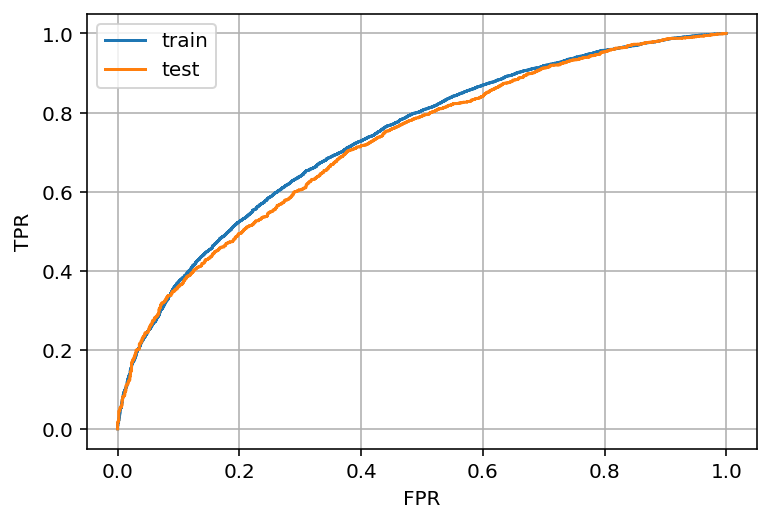

In [21]:
y_pred_lin_test = clf_lr.predict_proba(X_test)[:, 1]
y_pred_lin_train = clf_lr.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_lin_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_lin_test, 'test')
plt.grid()

plt.legend();

### Решающие деревья

1. Неустойчивы к входным данным
2. Склонны к переобучению
3. Быстро обучаются

=> хороший выбор для построения композиций


Обучаем решающее дерево

Ограничим глубину и минимальное кол-во объектов в листе для уменьшения переобучения

In [22]:
clf_tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)

Предсказываем вероятность класса 1 и считаем ROC AUC

Train:
ROC AUC: 0.7342
Test:
ROC AUC: 0.7125


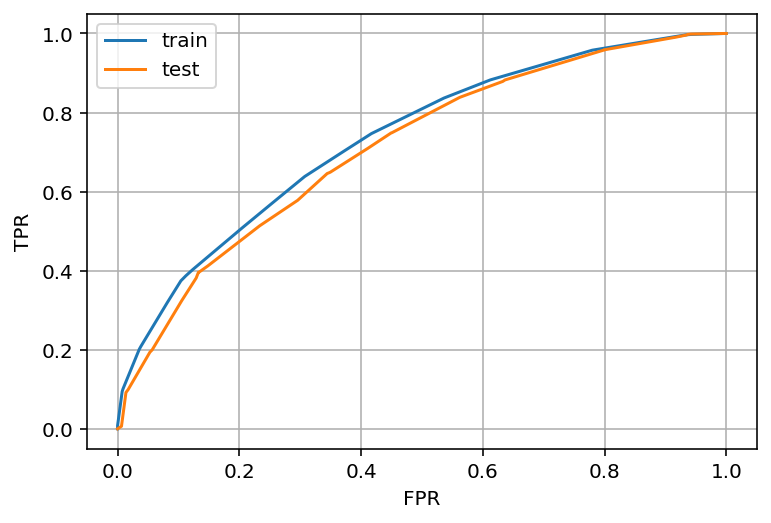

In [23]:
y_pred_train_tr = clf_tree.predict_proba(X_train)[:, 1]
y_pred_test_tr = clf_tree.predict_proba(X_test)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_tr, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_tr, 'test')
plt.grid()
plt.legend();

### Классификатор с голосованием

In [24]:
from sklearn.ensemble import VotingClassifier

In [25]:
voting_clf = VotingClassifier(
    estimators=[('DTree', clf_tree), ('LogR', clf_lr)], voting='soft', n_jobs=-1) 

In [26]:
%%time
voting_clf.fit(X_train, y_train)

Wall time: 3.67 s


VotingClassifier(estimators=[('DTree',
                              DecisionTreeClassifier(max_depth=5,
                                                     min_samples_leaf=10,
                                                     random_state=42)),
                             ('LogR',
                              LogisticRegression(C=0.01, random_state=42))],
                 n_jobs=-1, voting='soft')

Train:
ROC AUC: 0.7467
Test:
ROC AUC: 0.7282


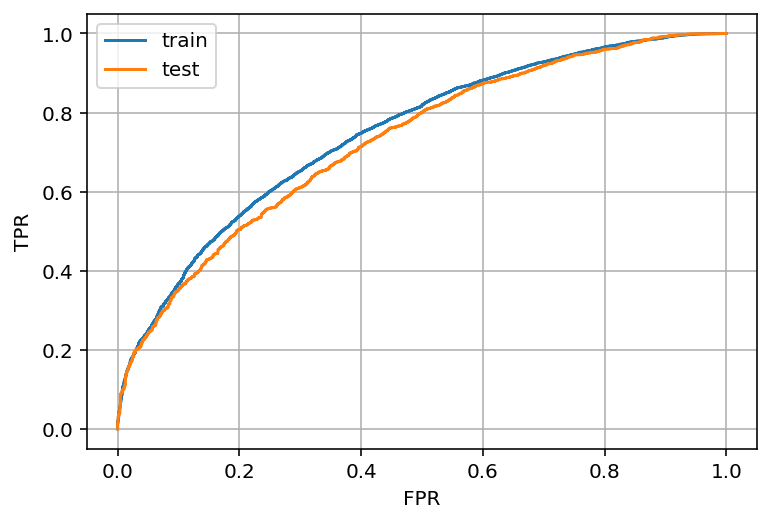

In [27]:
y_pred_test_vot = voting_clf.predict_proba(X_test)[:, 1]
y_pred_train_vot = voting_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_vot, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_vot, 'test')
plt.grid()
plt.legend();

## Композиции моделей одного семейства

### Бэггинг

Самостоятельная реализация

##### На дереве

In [28]:
%%time
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(n_estimators=20, base_estimator=clf_tree, n_jobs=-1, max_features=0.8, random_state=42)
bag_clf.fit(X_train, y_train)

Wall time: 5.87 s


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=10,
                                                        random_state=42),
                  max_features=0.8, n_estimators=20, n_jobs=-1,
                  random_state=42)

Train:
ROC AUC: 0.7535
Test:
ROC AUC: 0.7231


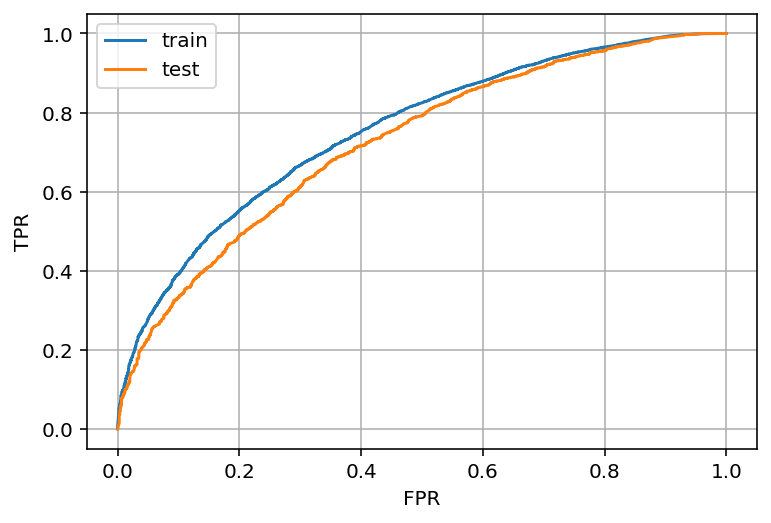

In [29]:
y_pred_test_bg = bag_clf.predict_proba(X_test)[:, 1]
y_pred_train_bg = bag_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_bg, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_bg, 'test')
plt.grid()
plt.legend();

##### Логистический

In [30]:
%%time
bag_clf_lr = BaggingClassifier(n_estimators=20, base_estimator=clf_lr, n_jobs=-1, random_state=42)
bag_clf_lr.fit(X_train, y_train)

Wall time: 17.1 s


BaggingClassifier(base_estimator=LogisticRegression(C=0.01, random_state=42),
                  n_estimators=20, n_jobs=-1, random_state=42)

Train:
ROC AUC: 0.7353
Test:
ROC AUC: 0.7224


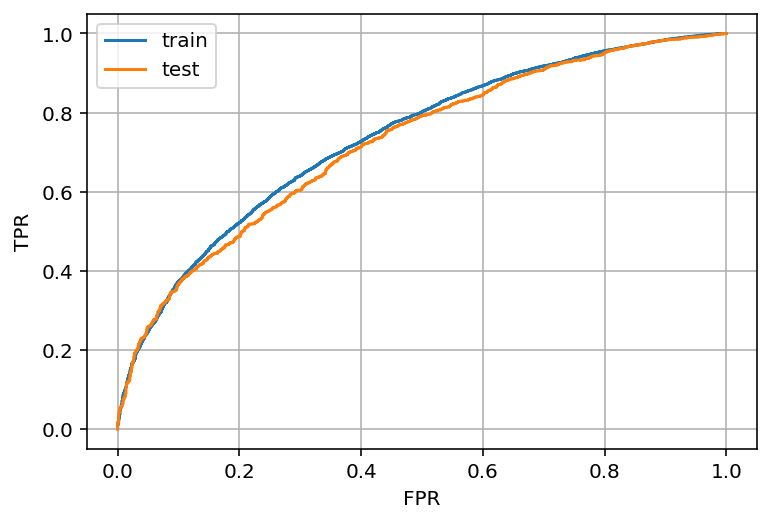

In [31]:
y_pred_test_bgLR = bag_clf_lr.predict_proba(X_test)[:, 1]
y_pred_train_bgLR = bag_clf_lr.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_train_bgLR, 'train')
print('Test:')
calc_auc(y_test, y_pred_test_bgLR, 'test')
plt.grid()
plt.legend();

# Часть 2. Случайный лес


**Важные гиперпараметры алгоритма**

a. Параметры деревьев
    1. criterion - критерий построения дерева
    2. max_depth - максимальная глубина дерева (обычно 10-20, больше глубина -> больше риск переобучения)
    3. min_samples_leaf - минимальное число объектов в листе (обычно 20+, больше объектов -> меньше риск переобучения)

b. Параметры леса
    1. n_estimators - кол-во деревьев (чем больше тем лучше)
    2. max_features - число признаков случайного подпространства
    3. bootstrap - использовать ли бэггинг
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)

In [32]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=14, random_state=42, 
                                criterion='entropy', min_samples_leaf=20, max_features=0.8, n_jobs=-1)

clf_rf.fit(X_train, y_train)    

Wall time: 41.5 s


RandomForestClassifier(criterion='entropy', max_depth=7, max_features=0.8,
                       min_samples_leaf=20, min_samples_split=14, n_jobs=-1,
                       random_state=42)

Train:
ROC AUC: 0.7914
Test:
ROC AUC: 0.7298


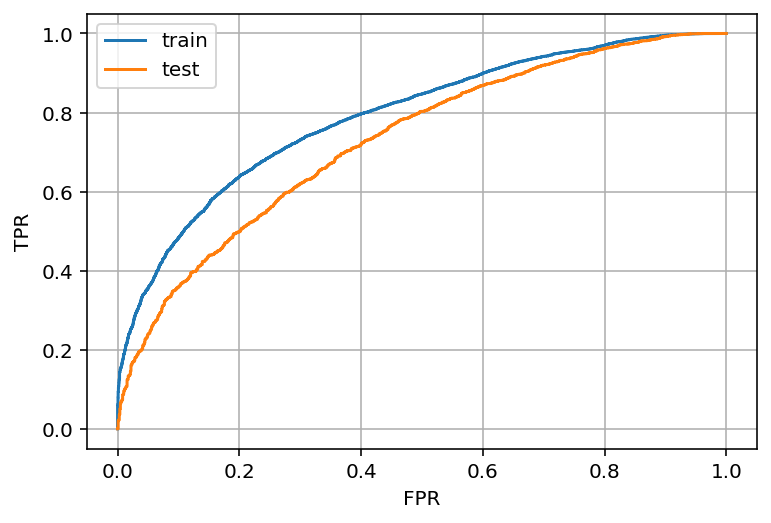

In [33]:
y_pred_rf_test = clf_rf.predict_proba(X_test)[:, 1]
y_pred_rf_train = clf_rf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_rf_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_rf_test, 'test')
plt.grid()
plt.legend();

#### Важность признаков

В sklearn - усредненное по всем деревьям в ансамбле кол-во сплитов по признаку, взвешенное на прирост информации (Information gain) и долю объектов в вершине, в которой производится этот сплит

Это не единственный вариант, см здесь:

https://medium.com/@ceshine/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3

Важности признаков случайного леса лежат в артибуте **feature\_importances\_**

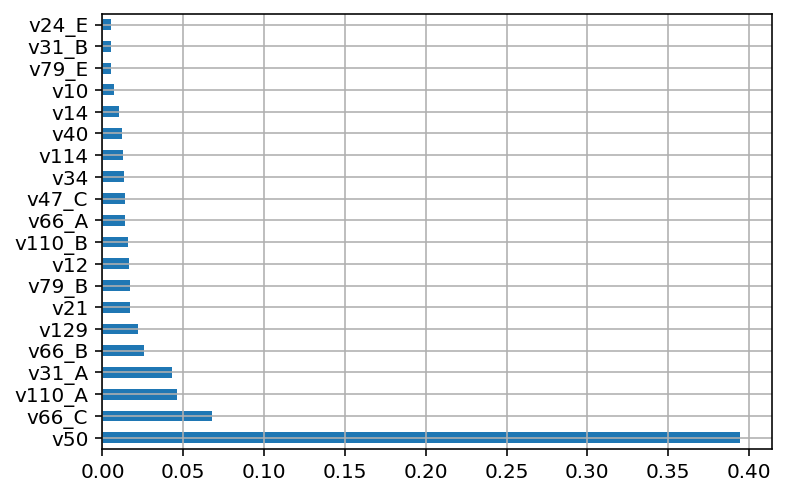

In [34]:
imp = pd.Series(clf_rf.feature_importances_, index=X_norm.columns).sort_values(ascending=False).iloc[:20].plot(kind='barh')
plt.grid();

### Особо случайное дерево

In [35]:
from sklearn.ensemble import ExtraTreesClassifier

In [36]:
clf_Erf = ExtraTreesClassifier(n_estimators=100, max_depth=7, min_samples_split=14, random_state=42, 
                                criterion='entropy', min_samples_leaf=20, max_features=0.8, n_jobs=-1)

In [37]:
%%time
clf_Erf.fit(X_train, y_train)

Wall time: 15.3 s


ExtraTreesClassifier(criterion='entropy', max_depth=7, max_features=0.8,
                     min_samples_leaf=20, min_samples_split=14, n_jobs=-1,
                     random_state=42)

Train:
ROC AUC: 0.7659
Test:
ROC AUC: 0.7306


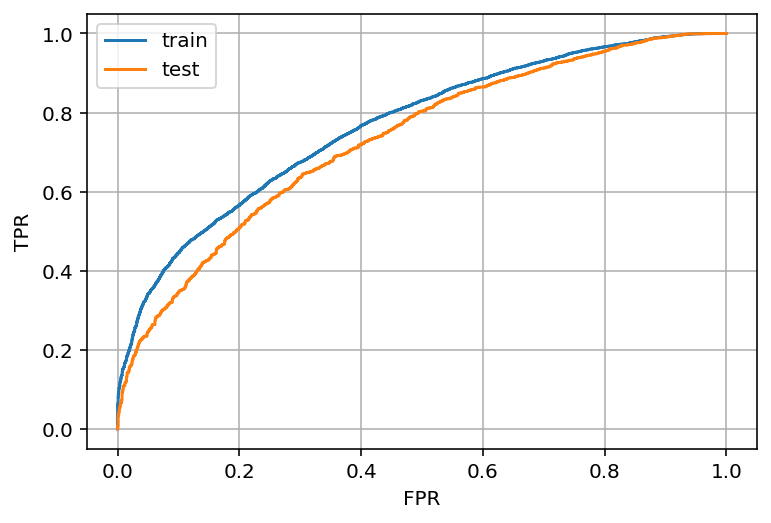

In [38]:
y_pred_Erf_test = clf_Erf.predict_proba(X_test)[:, 1]
y_pred_Erf_train = clf_Erf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_Erf_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_Erf_test, 'test')
plt.grid()
plt.legend();

# Часть 3. Композиции моделей разных типов

### Линейная комбинация моделей разного типа

Смешаем дерево и логистическую регрессию

Будем строить линейную комбинацию вида

$y = \alpha y_1 + (1 - \alpha) y_2$

Параметр $\alpha$ переберем по сетке от 0 до 1, оценивая качество на тестовой выборке

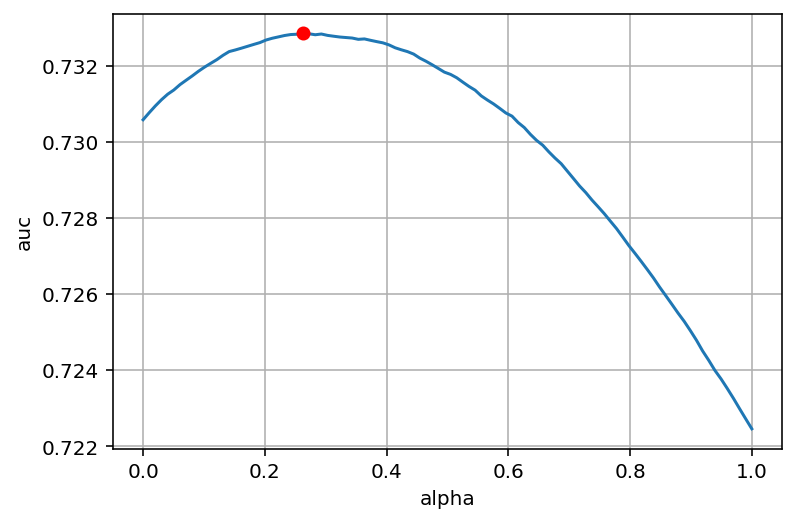

In [39]:
aucs = []
alpha_space = np.linspace(0, 1, 100)
for alpha in alpha_space:
    y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_Erf_test
    aucs.append(calc_auc(y_test, y_pred_weight, prin=False))
aucs = np.array(aucs)    

max_ind = np.where(aucs == aucs.max())[0]
alpha = alpha_space[max_ind]

plt.plot(alpha_space, aucs)
plt.plot(alpha_space[max_ind], aucs[max_ind], 'o', c='r')
plt.xlabel('alpha')
plt.ylabel('auc')
plt.grid()

#итоговое взвешенное предсказание
y_pred_weight = alpha * y_pred_lin_test + (1 - alpha) * y_pred_Erf_test

Weighted:
ROC AUC: 0.7328
Log regression:
ROC AUC: 0.7225
ExtraTrees:
ROC AUC: 0.7306


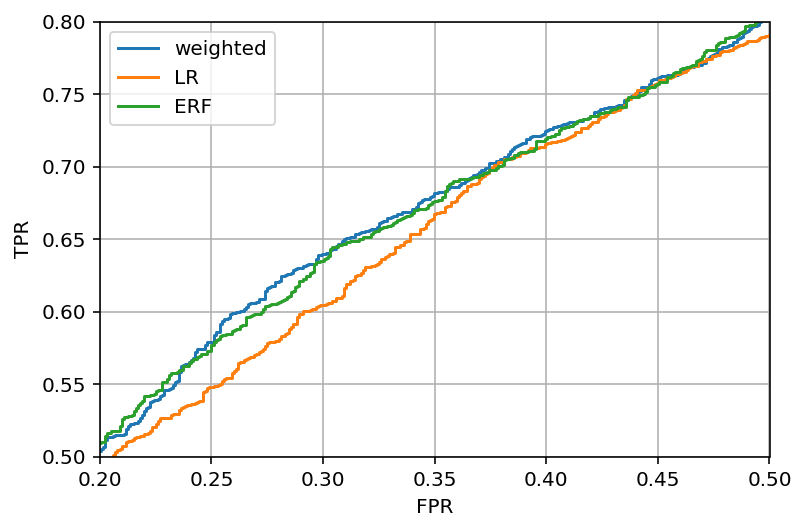

In [40]:
print('Weighted:')
calc_auc(y_test, y_pred_weight, 'weighted')
print('Log regression:')
calc_auc(y_test, y_pred_lin_test, 'LR')
print('ExtraTrees:')
calc_auc(y_test, y_pred_Erf_test, 'ERF')
plt.legend();
plt.xlim(0.2, 0.5)
plt.ylim(0.5, 0.8)
plt.grid();

## Стэкинг

### StackingClassifier

In [41]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

In [42]:
estimators = [
            ('rf', clf_rf),
            ('Etree', clf_Erf),
            ('Bagg',bag_clf)
            ]

In [43]:
Stac_clf = StackingClassifier(estimators=estimators, 
                              final_estimator=clf_Erf, n_jobs=-1, verbose=3)

In [44]:
%%time
Stac_clf.fit(X_train, y_train)

Wall time: 5min 43s


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       max_features=0.8,
                                                       min_samples_leaf=20,
                                                       min_samples_split=14,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('Etree',
                                ExtraTreesClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     max_features=0.8,
                                                     min_samples_leaf=20,
                                                     min_samples_split=14,
                                                   

Train:
ROC AUC: 0.7769
Test:
ROC AUC: 0.7333


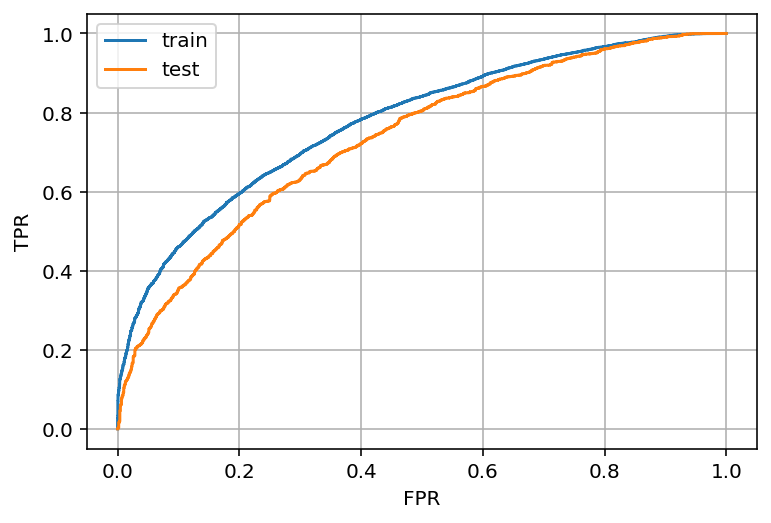

In [45]:
y_pred_Stac_test = Stac_clf.predict_proba(X_test)[:, 1]
y_pred_Stac_train = Stac_clf.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_Stac_train , 'train')
print('Test:')
calc_auc(y_test, y_pred_Stac_test, 'test')
plt.grid()
plt.legend();

## Бустинг в sklearn

In [1]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

#### Adaboost

Train:
ROC AUC: 0.7516
Test:
ROC AUC: 0.7311
Wall time: 35.8 s


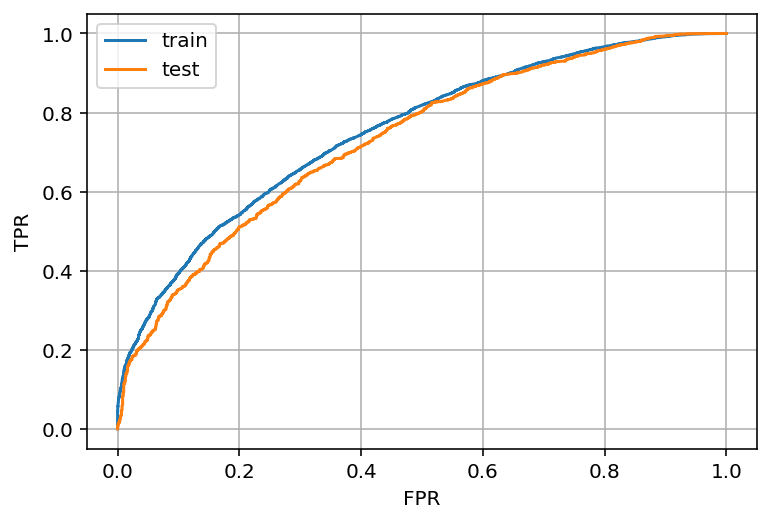

In [65]:
%%time
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_leaf=30, max_features=0.8, min_samples_split=30),
                             n_estimators=100, learning_rate=0.1, random_state=42)

clf_ada.fit(X_train, y_train)
y_pred_ada_test = clf_ada.predict_proba(X_test)[:, 1]
y_pred_ada_train = clf_ada.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_ada_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_ada_test, 'test')
plt.grid();
plt.legend();

#### GradientBoosting

Train:
ROC AUC: 0.7489
Test:
ROC AUC: 0.7321
Wall time: 26.8 s


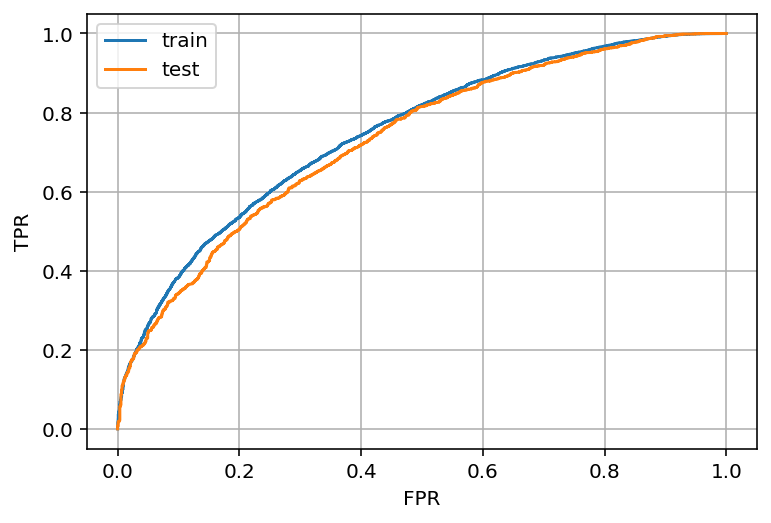

In [70]:
%%time
clf_gbm = GradientBoostingClassifier(max_depth=2, min_samples_leaf=30, n_estimators=100, learning_rate=0.1, 
                                     subsample=1.0, max_features=0.8, min_samples_split=30, random_state=42, 
                                     verbose=0)
# если subsample < 1.0 - получится стахастический градиентный спуск, алгоритм работать будет быстрее, 
# но точность может быть хуже

clf_gbm.fit(X_train, y_train)
y_pred_gbm_test = clf_gbm.predict_proba(X_test)[:, 1]
y_pred_gbm_train = clf_gbm.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_gbm_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_gbm_test, 'test')
plt.legend()
plt.grid();

## XGBOOST

In [71]:
import xgboost as xgb

**Важные гиперпараметры алгоритма**

a. Параметры деревьев

    1. max_depth - максимальная глубина дерева (обычно 3-10, больше глубина -> больше риск переобучения)
    2. min_child_weight - минимальное число объектов в листе (обычно до 20, больше объектов -> меньше риск переобучения, но должен быть согласован с глубиной дерева)
    3. gamma - минимально необходимый прирост качества для разбиения листа (редко используется)

b. Параметры бустинга

    0. objective - оптимизируемый функционал (встроен для классификации и регрессии, можно написать свой дифференцируемый)
    1. n_estimators - кол-во базовых алгоритмов (чем меньше learning_rate, тем больше деревьев)
    2. learning_rate - шаг создания ансамбля (зависит от n_estimators, но обычно 0.01 - 0.1)
    2. colsample_bytree - доля признаков, случайно выбирающихся для построения дерева
    3. subsample - доля объектов, случайно выбирающихся для построения дерева
    4. n_jobs - кол-во потоков для одновременного построения деревьев (большая прибавка к скорости на многоядерных процах)
    5. reg_alpha - вес L1 регуляризации (редко используется)
    6. reg_lambda - вес L2 регуляризации (редко используется)

Параметры по умолчанию

In [73]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}

In [74]:
%%time
clf_xgb = xgb.XGBClassifier(**params)
clf_xgb.fit(X_train, y_train)

Wall time: 10.2 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train:
ROC AUC: 0.7738
Test:
ROC AUC: 0.7332


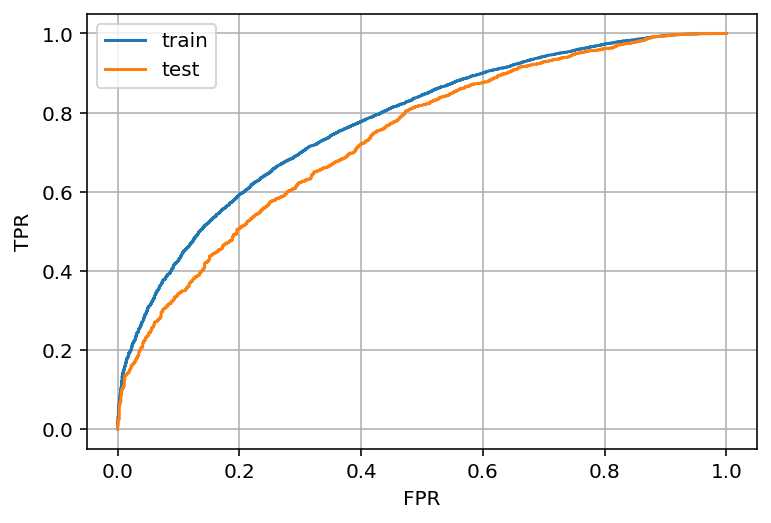

In [76]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

#### Онлайн оценка качества 

Во время обучения можно следить за качеством во время каждой итерации

Для этого используются параметры:
    1. eval_metric - метрика 'auc', 'rmse', 'logloss', ...
    2. eval_set - список выборок вида [(X, y), ...] на которых тестировать алгоритм

In [77]:
params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 3,
          'min_child_weight': 1,
          'subsample': 1,
          'colsample_bytree': 1,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.69674	validation_1-auc:0.69443
[1]	validation_0-auc:0.71393	validation_1-auc:0.71238
[2]	validation_0-auc:0.71513	validation_1-auc:0.71369
[3]	validation_0-auc:0.71860	validation_1-auc:0.71722
[4]	validation_0-auc:0.72114	validation_1-auc:0.71825
[5]	validation_0-auc:0.72341	validation_1-auc:0.72021
[6]	validation_0-auc:0.72543	validation_1-auc:0.72188
[7]	validation_0-auc:0.72579	validation_1-auc:0.72340
[8]	validation_0-auc:0.72627	validation_1-auc:0.72334
[9]	validation_0-auc:0.72669	validation_1-auc:0.72431
[10]	validation_0-auc:0.72728	validation_1-auc:0.72533
[11]	validation_0-auc:0.72785	validation_1-auc:0.72466
[12]	validation_0-auc:0.72820	validation_1-auc:0.72581
[13]	validation_0-auc:0.72952	validation_1-auc:0.72708
[14]	validation_0-auc:0.73114	validation_1-auc:0.72687
[15]	validation_0-auc:0.73163	validation_1-auc:0.72723
[16]	validation_0-auc:0.73169	validation_1-auc:0.72783
[17]	validation_0-auc:0.73292	validation_1-auc:0.72777
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Возмем параметры, с которых лучше всего начать

In [78]:
%%time

params = {'n_estimators': 100,
          'learning_rate': 0.1,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.73255	validation_1-auc:0.71462
[1]	validation_0-auc:0.74291	validation_1-auc:0.71973
[2]	validation_0-auc:0.74929	validation_1-auc:0.72283
[3]	validation_0-auc:0.75077	validation_1-auc:0.72373
[4]	validation_0-auc:0.75269	validation_1-auc:0.72409
[5]	validation_0-auc:0.75419	validation_1-auc:0.72402
[6]	validation_0-auc:0.75629	validation_1-auc:0.72429
[7]	validation_0-auc:0.75769	validation_1-auc:0.72361
[8]	validation_0-auc:0.75888	validation_1-auc:0.72303
[9]	validation_0-auc:0.76137	validation_1-auc:0.72194
[10]	validation_0-auc:0.76275	validation_1-auc:0.72323
[11]	validation_0-auc:0.76444	validation_1-auc:0.72562
[12]	validation_0-auc:0.76608	validation_1-auc:0.72569
[13]	validation_0-auc:0.76646	validation_1-auc:0.72642
[14]	validation_0-auc:0.76703	validation_1-auc:0.72789
[15]	validation_0-auc:0.76840	validation_1-auc:0.72813
[16]	validation_0-auc:0.77021	validation_1-auc:0.72764
[17]	validation_0-auc:0.77143	validation_1-auc:0.72768
[18]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

###### Достанем из объекта clf_xgb списки результатов метрик по итерациям, построим графики

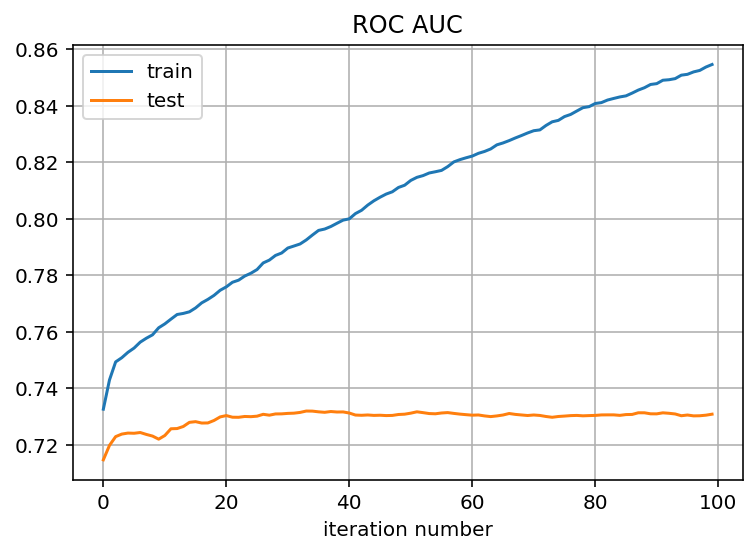

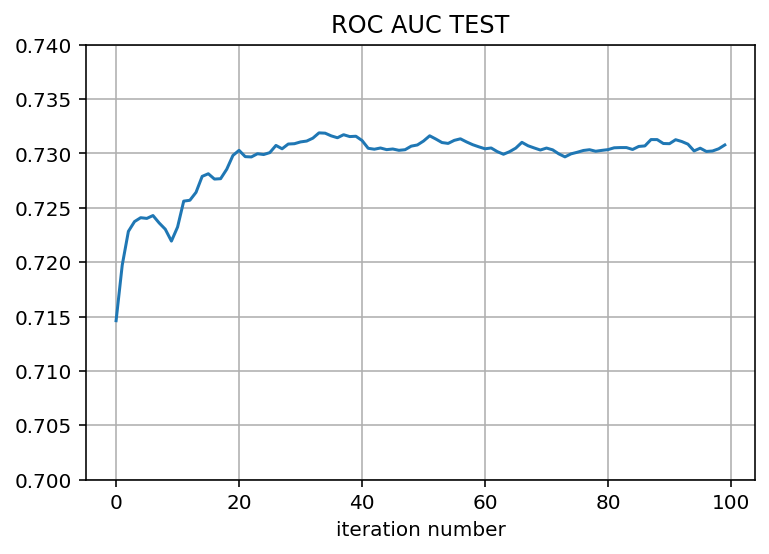

In [85]:
def save_online_metric(clf):
    return pd.DataFrame({'train': clf.evals_result()['validation_0']['auc'],
                         'test': clf.evals_result()['validation_1']['auc']})
res = save_online_metric(clf_xgb)
res.plot(title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.7, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

###### Нужно побороть переобучение, уменьшим learning_rate. Также уменьшим кол-во деревьев для ускорения обучения

In [90]:
%%time
params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': -1}
clf_xgb = xgb.XGBClassifier(**params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

best_params = params

[0]	validation_0-auc:0.73255	validation_1-auc:0.71462
[1]	validation_0-auc:0.74125	validation_1-auc:0.71800
[2]	validation_0-auc:0.74476	validation_1-auc:0.72193
[3]	validation_0-auc:0.74705	validation_1-auc:0.72329
[4]	validation_0-auc:0.74833	validation_1-auc:0.72452
[5]	validation_0-auc:0.74926	validation_1-auc:0.72465
[6]	validation_0-auc:0.75092	validation_1-auc:0.72323
[7]	validation_0-auc:0.75254	validation_1-auc:0.72374
[8]	validation_0-auc:0.75322	validation_1-auc:0.72422
[9]	validation_0-auc:0.75458	validation_1-auc:0.72301
[10]	validation_0-auc:0.75506	validation_1-auc:0.72323
[11]	validation_0-auc:0.75575	validation_1-auc:0.72373
[12]	validation_0-auc:0.75651	validation_1-auc:0.72376
[13]	validation_0-auc:0.75704	validation_1-auc:0.72467
[14]	validation_0-auc:0.75706	validation_1-auc:0.72525
[15]	validation_0-auc:0.75750	validation_1-auc:0.72500
[16]	validation_0-auc:0.75858	validation_1-auc:0.72507
[17]	validation_0-auc:0.75884	validation_1-auc:0.72478
[18]	validation_0-au

### Перебор параметров по сетке

Опишем функцию, похожую на GridSearchCV, только для одной отложенной выборки X_test. Она перебирает параметки по заданной сетке и возврашает лучшие по ROC AUC

In [91]:
def find_params(clf, param_grid):
    clf = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=[(np.arange(len(X_train)),
                                                               np.arange(len(X_test)) + len(X_train))],
                  verbose=3)

    clf.fit(pd.concat([X_train, X_test]).values, pd.concat([y_train, y_test]).values)
    best_params = clf.best_estimator_.get_params()
    print('Best test ROC AUC: ', clf.best_score_)
    print('Best params: ', best_params)
    return best_params

**Процесс подбора параметров**:

1. Зафиксируем learning_rate и n_estimators, чтобы модель не переобучалась во время итераций
2. Настраиваем параметры деревьев: max_depth и min_child_weight
3. Настраиваем gamma (опционально)
4. Настраиваем subsample и colsample_bytree
5. Настраиваем регуляризацию reg_lambda и reg_alpha
6. Уменьшаем learning_rate, увеличиваем кол-во деревьев и обучаем заново на лучших параметрах

#### Подбираем max_depth и min_child_weight

In [92]:
%%time

from sklearn.model_selection import GridSearchCV

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_child_weight': [10, 20, 100]#[1, 5, 10]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[CV] max_depth=3, min_child_weight=10 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .... max_depth=3, min_child_weight=10, score=0.729, total=   4.7s
[CV] max_depth=3, min_child_weight=20 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] .... max_depth=3, min_child_weight=20, score=0.728, total=   4.4s
[CV] max_depth=3, min_child_weight=100 ...............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


[CV] ... max_depth=3, min_child_weight=100, score=0.725, total=   4.8s
[CV] max_depth=5, min_child_weight=10 ................................
[CV] .... max_depth=5, min_child_weight=10, score=0.731, total=   6.8s
[CV] max_depth=5, min_child_weight=20 ................................
[CV] .... max_depth=5, min_child_weight=20, score=0.731, total=   7.9s
[CV] max_depth=5, min_child_weight=100 ...............................
[CV] ... max_depth=5, min_child_weight=100, score=0.729, total=   7.7s
[CV] max_depth=10, min_child_weight=10 ...............................
[CV] ... max_depth=10, min_child_weight=10, score=0.728, total=  12.8s
[CV] max_depth=10, min_child_weight=20 ...............................
[CV] ... max_depth=10, min_child_weight=20, score=0.728, total=  12.6s
[CV] max_depth=10, min_child_weight=100 ..............................
[CV] .. max_depth=10, min_child_weight=100, score=0.730, total=   8.3s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min finished


Best test ROC AUC:  0.7310195430347686
Best params:  {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 20, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Wall time: 1min 19s


#### Подбираем gamma

In [93]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'gamma': np.linspace(0, 0.5, 5)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV] gamma=0.0 .......................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................... gamma=0.0, score=0.731, total=   6.6s
[CV] gamma=0.125 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s


[CV] ......................... gamma=0.125, score=0.731, total=   6.5s
[CV] gamma=0.25 ......................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s


[CV] .......................... gamma=0.25, score=0.731, total=   6.4s
[CV] gamma=0.375 .....................................................
[CV] ......................... gamma=0.375, score=0.731, total=   6.5s
[CV] gamma=0.5 .......................................................
[CV] ........................... gamma=0.5, score=0.731, total=   6.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   32.8s finished


Best test ROC AUC:  0.7312597270583481
Best params:  {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 20, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Wall time: 40.8 s


#### Подбираем subsample и colsample_bytree

In [94]:
%%time
clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'subsample': np.linspace(0.5, 1, 6),
    'colsample_bytree': np.linspace(0.5, 1, 6)
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 36 candidates, totalling 36 fits
[CV] colsample_bytree=0.5, subsample=0.5 .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . colsample_bytree=0.5, subsample=0.5, score=0.728, total=   4.5s
[CV] colsample_bytree=0.5, subsample=0.6 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] . colsample_bytree=0.5, subsample=0.6, score=0.727, total=   4.4s
[CV] colsample_bytree=0.5, subsample=0.7 .............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.8s remaining:    0.0s


[CV] . colsample_bytree=0.5, subsample=0.7, score=0.729, total=   4.5s
[CV] colsample_bytree=0.5, subsample=0.8 .............................
[CV] . colsample_bytree=0.5, subsample=0.8, score=0.728, total=   4.5s
[CV] colsample_bytree=0.5, subsample=0.9 .............................
[CV] . colsample_bytree=0.5, subsample=0.9, score=0.729, total=   4.5s
[CV] colsample_bytree=0.5, subsample=1.0 .............................
[CV] . colsample_bytree=0.5, subsample=1.0, score=0.728, total=   4.5s
[CV] colsample_bytree=0.6, subsample=0.5 .............................
[CV] . colsample_bytree=0.6, subsample=0.5, score=0.730, total=   4.8s
[CV] colsample_bytree=0.6, subsample=0.6 .............................
[CV] . colsample_bytree=0.6, subsample=0.6, score=0.730, total=   5.0s
[CV] colsample_bytree=0.6, subsample=0.7 .............................
[CV] . colsample_bytree=0.6, subsample=0.7, score=0.731, total=   5.0s
[CV] colsample_bytree=0.6, subsample=0.8 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  3.8min finished


Best test ROC AUC:  0.7324384176581821
Best params:  {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 20, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Wall time: 4min


#### Подбираем регуляризацию: reg_lambda и reg_alpha

In [95]:
%%time

clf_xgb = xgb.XGBClassifier(**best_params)

param_grid = {
    'reg_alpha': [0, 0.0001, 0.001, 0.1, 1],
    'reg_lambda': [0, 0.0001, 0.001, 0.1, 1]
}

best_params = find_params(clf_xgb, param_grid)

Fitting 1 folds for each of 25 candidates, totalling 25 fits
[CV] reg_alpha=0, reg_lambda=0 .......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........... reg_alpha=0, reg_lambda=0, score=0.732, total=   6.1s
[CV] reg_alpha=0, reg_lambda=0.0001 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.0s remaining:    0.0s


[CV] ...... reg_alpha=0, reg_lambda=0.0001, score=0.732, total=   5.9s
[CV] reg_alpha=0, reg_lambda=0.001 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s


[CV] ....... reg_alpha=0, reg_lambda=0.001, score=0.732, total=   5.8s
[CV] reg_alpha=0, reg_lambda=0.1 .....................................
[CV] ......... reg_alpha=0, reg_lambda=0.1, score=0.732, total=   5.9s
[CV] reg_alpha=0, reg_lambda=1 .......................................
[CV] ........... reg_alpha=0, reg_lambda=1, score=0.732, total=   5.8s
[CV] reg_alpha=0.0001, reg_lambda=0 ..................................
[CV] ...... reg_alpha=0.0001, reg_lambda=0, score=0.732, total=   5.7s
[CV] reg_alpha=0.0001, reg_lambda=0.0001 .............................
[CV] . reg_alpha=0.0001, reg_lambda=0.0001, score=0.732, total=   5.8s
[CV] reg_alpha=0.0001, reg_lambda=0.001 ..............................
[CV] .. reg_alpha=0.0001, reg_lambda=0.001, score=0.732, total=   5.7s
[CV] reg_alpha=0.0001, reg_lambda=0.1 ................................
[CV] .... reg_alpha=0.0001, reg_lambda=0.1, score=0.732, total=   6.1s
[CV] reg_alpha=0.0001, reg_lambda=1 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.6min finished


Best test ROC AUC:  0.7328818241989744
Best params:  {'objective': 'binary:logistic', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.7, 'gamma': 0.5, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 20, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 50, 'n_jobs': -1, 'num_parallel_tree': 1, 'random_state': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}
Wall time: 2min 42s


#### Уменьшим learning_rate

In [96]:
%%time

best_params['learning_rate'] = 0.01
best_params['n_estimators'] = 500

clf_xgb = xgb.XGBClassifier(**best_params)

clf_xgb.fit(X_train, y_train, eval_metric='auc', eval_set=[[X_train, y_train], [X_test, y_test]])

[0]	validation_0-auc:0.68895	validation_1-auc:0.66182
[1]	validation_0-auc:0.73177	validation_1-auc:0.70956
[2]	validation_0-auc:0.73959	validation_1-auc:0.71812
[3]	validation_0-auc:0.74252	validation_1-auc:0.72215
[4]	validation_0-auc:0.74403	validation_1-auc:0.72540
[5]	validation_0-auc:0.74483	validation_1-auc:0.72555
[6]	validation_0-auc:0.74491	validation_1-auc:0.72575
[7]	validation_0-auc:0.74601	validation_1-auc:0.72631
[8]	validation_0-auc:0.74641	validation_1-auc:0.72671
[9]	validation_0-auc:0.74623	validation_1-auc:0.72497
[10]	validation_0-auc:0.74627	validation_1-auc:0.72537
[11]	validation_0-auc:0.74620	validation_1-auc:0.72628
[12]	validation_0-auc:0.74621	validation_1-auc:0.72607
[13]	validation_0-auc:0.74667	validation_1-auc:0.72619
[14]	validation_0-auc:0.74680	validation_1-auc:0.72700
[15]	validation_0-auc:0.74706	validation_1-auc:0.72664
[16]	validation_0-auc:0.74714	validation_1-auc:0.72590
[17]	validation_0-auc:0.74731	validation_1-auc:0.72623
[18]	validation_0-au

[149]	validation_0-auc:0.76201	validation_1-auc:0.73137
[150]	validation_0-auc:0.76209	validation_1-auc:0.73143
[151]	validation_0-auc:0.76226	validation_1-auc:0.73134
[152]	validation_0-auc:0.76235	validation_1-auc:0.73140
[153]	validation_0-auc:0.76238	validation_1-auc:0.73140
[154]	validation_0-auc:0.76243	validation_1-auc:0.73150
[155]	validation_0-auc:0.76246	validation_1-auc:0.73153
[156]	validation_0-auc:0.76258	validation_1-auc:0.73148
[157]	validation_0-auc:0.76264	validation_1-auc:0.73153
[158]	validation_0-auc:0.76277	validation_1-auc:0.73155
[159]	validation_0-auc:0.76280	validation_1-auc:0.73166
[160]	validation_0-auc:0.76290	validation_1-auc:0.73166
[161]	validation_0-auc:0.76298	validation_1-auc:0.73164
[162]	validation_0-auc:0.76307	validation_1-auc:0.73159
[163]	validation_0-auc:0.76310	validation_1-auc:0.73159
[164]	validation_0-auc:0.76322	validation_1-auc:0.73150
[165]	validation_0-auc:0.76324	validation_1-auc:0.73152
[166]	validation_0-auc:0.76325	validation_1-auc:

[296]	validation_0-auc:0.77381	validation_1-auc:0.73321
[297]	validation_0-auc:0.77389	validation_1-auc:0.73319
[298]	validation_0-auc:0.77398	validation_1-auc:0.73312
[299]	validation_0-auc:0.77407	validation_1-auc:0.73313
[300]	validation_0-auc:0.77419	validation_1-auc:0.73315
[301]	validation_0-auc:0.77427	validation_1-auc:0.73316
[302]	validation_0-auc:0.77433	validation_1-auc:0.73322
[303]	validation_0-auc:0.77442	validation_1-auc:0.73319
[304]	validation_0-auc:0.77448	validation_1-auc:0.73318
[305]	validation_0-auc:0.77450	validation_1-auc:0.73316
[306]	validation_0-auc:0.77453	validation_1-auc:0.73319
[307]	validation_0-auc:0.77456	validation_1-auc:0.73320
[308]	validation_0-auc:0.77465	validation_1-auc:0.73315
[309]	validation_0-auc:0.77475	validation_1-auc:0.73315
[310]	validation_0-auc:0.77481	validation_1-auc:0.73316
[311]	validation_0-auc:0.77484	validation_1-auc:0.73315
[312]	validation_0-auc:0.77488	validation_1-auc:0.73313
[313]	validation_0-auc:0.77500	validation_1-auc:

[443]	validation_0-auc:0.78418	validation_1-auc:0.73393
[444]	validation_0-auc:0.78421	validation_1-auc:0.73395
[445]	validation_0-auc:0.78432	validation_1-auc:0.73397
[446]	validation_0-auc:0.78438	validation_1-auc:0.73395
[447]	validation_0-auc:0.78441	validation_1-auc:0.73391
[448]	validation_0-auc:0.78449	validation_1-auc:0.73394
[449]	validation_0-auc:0.78457	validation_1-auc:0.73396
[450]	validation_0-auc:0.78462	validation_1-auc:0.73396
[451]	validation_0-auc:0.78468	validation_1-auc:0.73399
[452]	validation_0-auc:0.78481	validation_1-auc:0.73396
[453]	validation_0-auc:0.78496	validation_1-auc:0.73396
[454]	validation_0-auc:0.78503	validation_1-auc:0.73394
[455]	validation_0-auc:0.78512	validation_1-auc:0.73389
[456]	validation_0-auc:0.78524	validation_1-auc:0.73389
[457]	validation_0-auc:0.78536	validation_1-auc:0.73387
[458]	validation_0-auc:0.78546	validation_1-auc:0.73384
[459]	validation_0-auc:0.78552	validation_1-auc:0.73387
[460]	validation_0-auc:0.78555	validation_1-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=20, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

###### Визуализируем метрику в зависимости от итерации

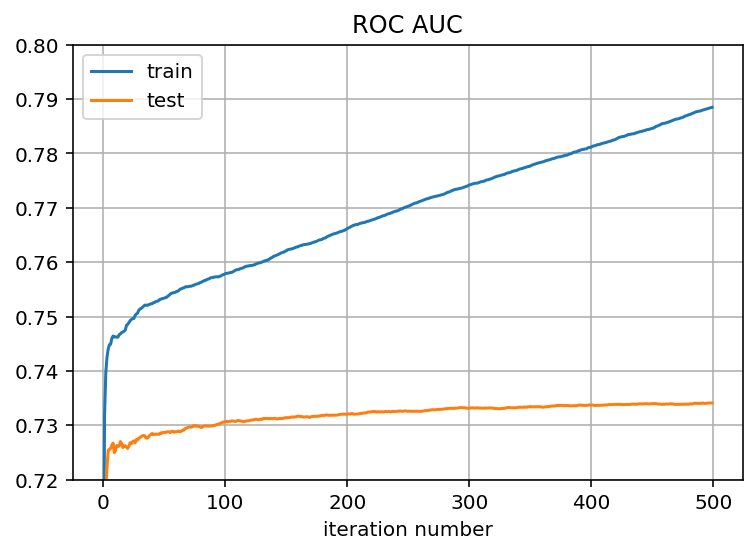

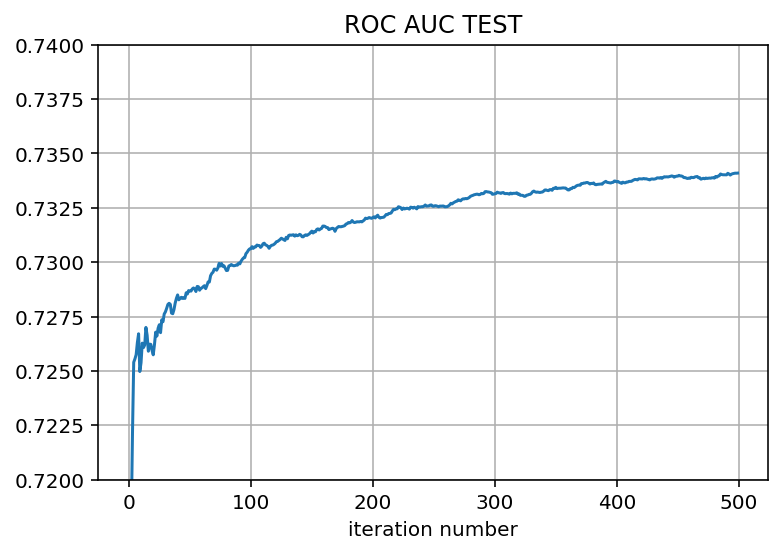

In [98]:
res = save_online_metric(clf_xgb)
res.plot(ylim=(0.72, 0.8), title='ROC AUC')
plt.xlabel('iteration number')
plt.grid();
plt.figure()
res.test.plot(ylim=(0.72, 0.74), title='ROC AUC TEST')
plt.xlabel('iteration number')
plt.grid();

### HyperOpt

http://hyperopt.github.io/hyperopt/

Инструмент для автоматической "умной" оптимизации большого числа гиперпараметров. Использует алгоритм Tree of Parzen Estimators.

Основная идея библиотеки hyperopt — это построение математической гипотезы о том как выглядит функция результа на множества параметров и проверка этой гипотезы с каждой итерацией.

In [112]:
%%time

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 100,
         'learning_rate': 0.1
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

Training with params :                                                         
{'colsample_bytree': 0.9, 'gamma': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.75, 'n_jobs': -1}
[23:26:17] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TEST ROC AUC: 0.7315                                                           
Training with params :                                                         
{'colsample_bytree': 0.8500000000000001, 'gamma': 0.65, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 7.0, 'n_estimators': 100, 'silent': 1, 'subsample': 0.9, 'n_jobs': -1}
[23:26:27] WARNING: C

In [113]:
best

{'colsample_bytree': 0.75,
 'gamma': 0.75,
 'max_depth': 3.0,
 'min_child_weight': 3.0,
 'subsample': 0.6000000000000001}

In [114]:
trials.best_trial

{'state': 2,
 'tid': 14,
 'spec': None,
 'result': {'loss': 0.26582241850842825, 'status': 'ok'},
 'misc': {'tid': 14,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [14],
   'gamma': [14],
   'max_depth': [14],
   'min_child_weight': [14],
   'subsample': [14]},
  'vals': {'colsample_bytree': [0.75],
   'gamma': [0.75],
   'max_depth': [3.0],
   'min_child_weight': [3.0],
   'subsample': [0.6000000000000001]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 12, 14, 21, 28, 51, 751000),
 'refresh_time': datetime.datetime(2020, 12, 14, 21, 28, 59, 510000)}

#### Построение по лучшим параметрам

In [125]:
best_new = {'colsample_bytree': 0.75,
 'gamma': 0.75,
 'max_depth': 3,
 'min_child_weight': 3.0,
 'subsample': 0.6000000000000001,
 'n_estimators': 100,
 'learning_rate': 0.1         
}

In [126]:
%%time
clf_xgb = xgb.XGBClassifier(**best_new)
clf_xgb.fit(X_train, y_train)

Wall time: 7.89 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.75, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6000000000000001, tree_method='exact',
              validate_parameters=1, verbosity=None)

Train:
ROC AUC: 0.7732
Test:
ROC AUC: 0.7342


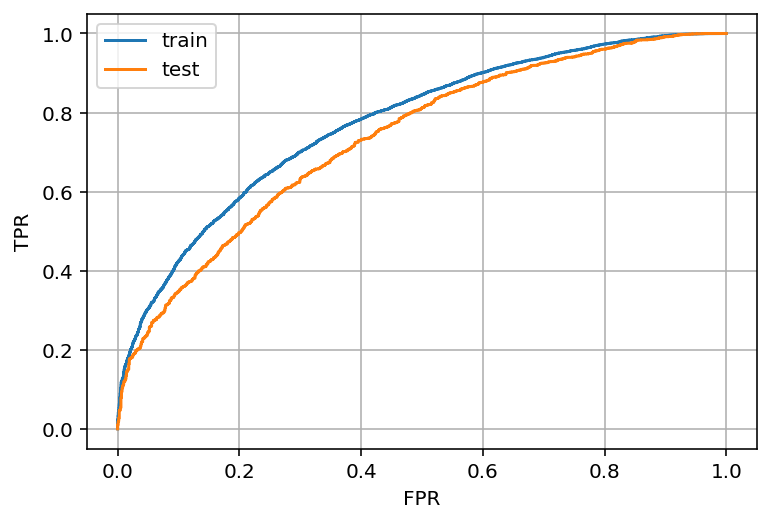

In [127]:
y_pred_xgb_test = clf_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb_train = clf_xgb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.grid()
plt.legend();

### Важность признаков

#### Встроенные методы

Нужно вытащить из sklearn обертки оригинальный объект класса xgboost.core.Booster

Есть 3 типа важности в get_score():

    weight - суммарное кол-во раз, когда признак использовался для разбиения вершины
    gain - средний прирост качества, когда признак использовался для разбиения вершины
    cover - среднее кол-во объектов, которые попадали в разбиение по признаку, когда он использовался для разбиения вершины

Wall time: 494 ms


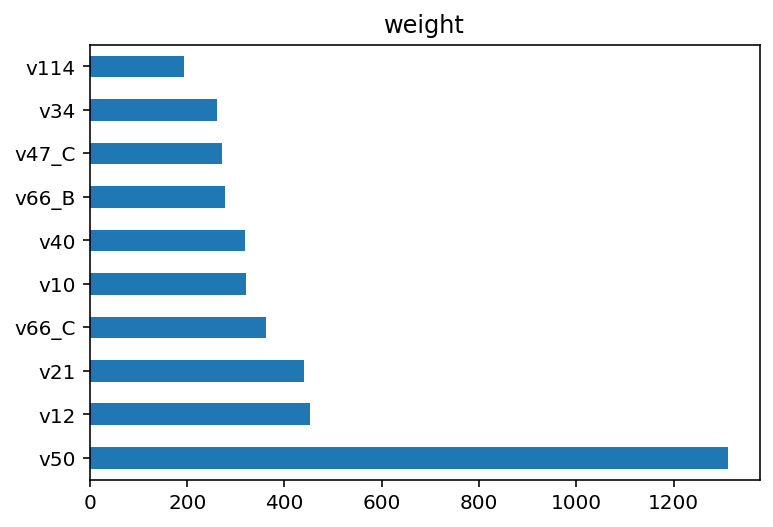

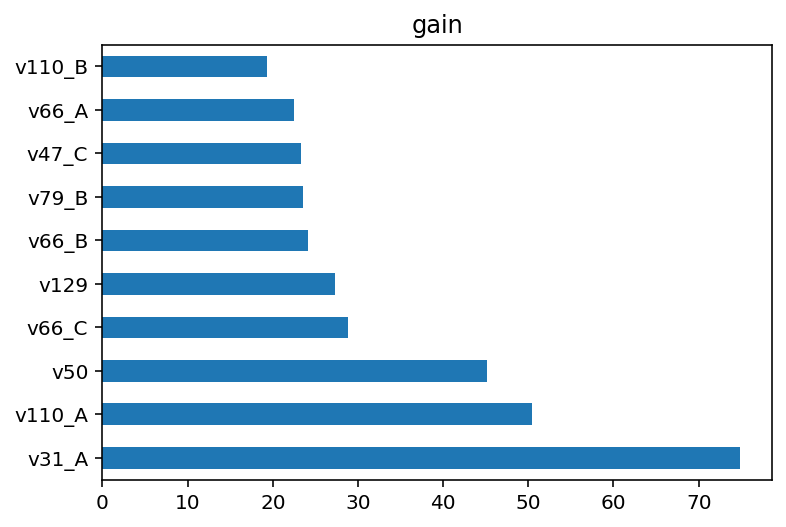

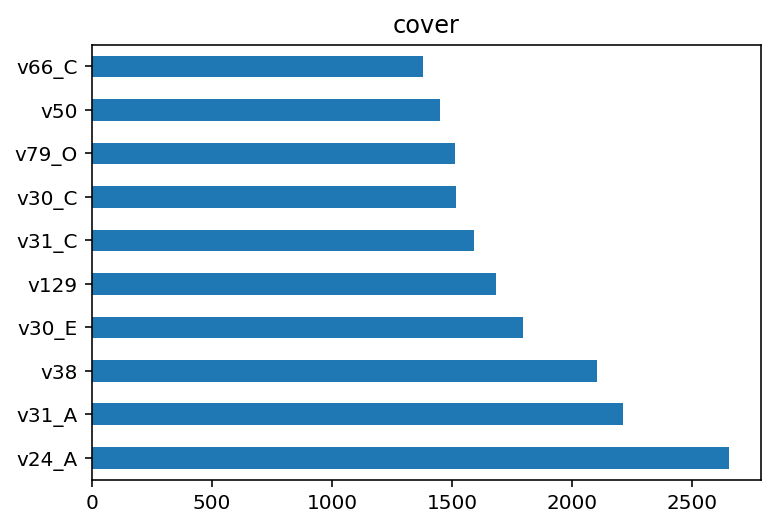

In [102]:
%%time

bst = clf_xgb.get_booster()

for kind in ['weight', 'gain', 'cover']:
    imp = pd.Series(bst.get_score(importance_type=kind))
    plt.figure()
    imp.sort_values(ascending=False).iloc[:10].plot(kind='barh', title=kind)

#### XGBFI

Позволяет оценивать важности взаимодействия признаков

https://github.com/limexp/xgbfir

In [1]:
import xgbfir
xgbfir.saveXgbFI(clf_xgb, OutputXlsxFile='xgbfi_report.xlsx')

NameError: name 'clf_xgb' is not defined

In [108]:
pd.read_excel('xgbfi_report.xlsx', sheet_name=0)

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,v50,39001.806344,453,154.414074,0.340870,86.096703,31258.378522,1,1,1,5,2,1,1.833333,47.481236,2.256071
1,v66_C,7256.582910,141,39.280479,0.278585,51.465127,2353.812232,2,2,2,10,4,3,3.833333,47.283688,2.333333
2,v31_A,5750.995392,56,31.637521,0.564956,102.696346,5206.516689,3,13,4,1,1,2,4.000000,50.000000,1.357143
3,v110_A,4592.045340,67,22.516947,0.336074,68.537990,1856.131687,4,10,5,6,3,4,5.333333,46.791045,1.850746
4,v47_C,4133.375005,108,34.568697,0.320081,38.271991,1685.112194,5,6,3,8,7,5,5.666667,45.759259,2.287037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,v79_K,16.422373,3,0.111355,0.037118,5.474124,0.587081,96,93,96,94,69,98,91.000000,31.333333,3.666667
96,v43,16.183966,5,0.118902,0.023780,3.236793,0.453083,97,73,95,99,98,99,93.500000,40.600000,3.800000
97,v69,15.804565,4,0.449483,0.112371,3.951141,1.097405,98,81,63,32,92,89,75.833333,51.000000,4.000000
98,v79_O,15.430054,3,0.402239,0.134080,5.143351,2.373266,99,94,67,23,75,68,71.000000,59.666667,3.666667


## CatBoost

In [2]:
from catboost import CatBoostClassifier, Pool

In [193]:
train_data = X_train
train_labels = y_train
eval_data = X_test
eval_labels = y_test
eval_dataset = Pool(eval_data,
                    eval_labels)





clf_catb = CatBoostClassifier(
                           l2_leaf_reg=4000,
                           iterations=1000,
                           learning_rate=0.3,
                           eval_metric='AUC',
                            max_depth=7,
                           loss_function='CrossEntropy',
                           use_best_model=True,
                           custom_metric=['Accuracy',
                                          'AUC:hints=skip_train~false'],
                                                     )

In [194]:
clf_catb.fit(train_data,
          train_labels,
          eval_set=eval_dataset,
          verbose=False,
          plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Train:
ROC AUC: 0.8113
Test:
ROC AUC: 0.7354


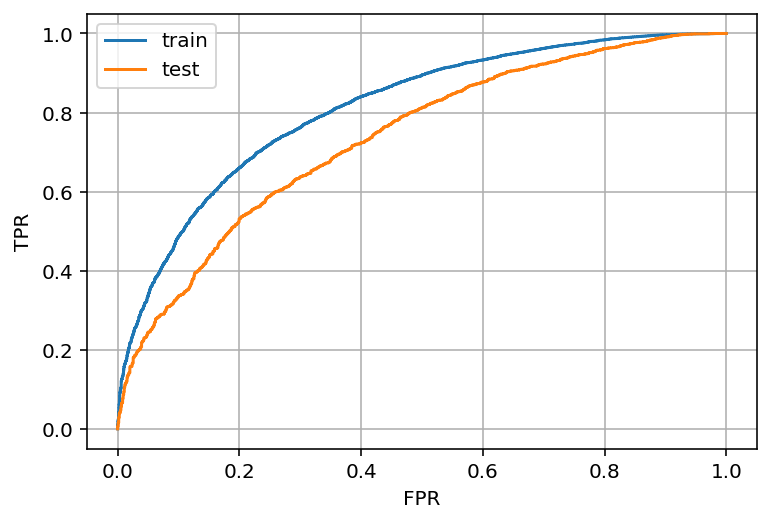

In [195]:
y_pred_catb_test = clf_catb.predict_proba(X_test)[:, 1]
y_pred_catb_train = clf_catb.predict_proba(X_train)[:, 1]

print('Train:')
calc_auc(y_train, y_pred_catb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_catb_test, 'test')
plt.grid()
plt.legend();